In [1]:
from numpy.linalg import norm
import numpy as np
import os
import os.path
from os import path
import sys
import glob
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg')
import plotly.graph_objects as go
from plotly.graph_objs import *
import plotly.express as px
import hdbscan
import pandas as pd
import umap
from graviti import *
import networkx as nx
from scipy import sparse, linalg
import pickle

import multiprocessing
from joblib import Parallel, delayed


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Contour visualization
def contourPlot(fdf,N,filename):
    fdf['field'] = np.log(0.5*delta) # define the laplacian field and mult by 0.5 because of double counting edges
    fdf['x_bin'] = pd.cut(fdf['Centroid X µm'], N, labels=False) # define the x bin label
    fdf['y_bin'] = pd.cut(fdf['Centroid Y µm'], N, labels=False) # define the y bin label

    # define the pivot tabel for the contour plot
    table = pd.pivot_table(fdf, 
                           values='field', 
                           index=['x_bin'],
                           columns=['y_bin'],
                           aggfunc=np.sum, # take the mean of the entries in the bin
                           fill_value=None)

    X=table.columns.values
    Y=table.index.values
    Z=table.values
    Xi,Yi = np.meshgrid(X, Y)

    fig, ax = plt.subplots(figsize=(15,10))
    cs = ax.contourf(Yi, Xi, Z, 
                     alpha=1.0, 
                     levels=10,
                     cmap=plt.cm.viridis) ;
    cbar = fig.colorbar(cs)
    plt.gca().invert_yaxis() # to vertically flip the image
    plt.savefig(filename)
    return

In [18]:
size = 0 # number of nuclei, use 0 value for full set
nn = 10 # set the number of nearest neighbor in the umap-graph. Will be used in CovD as well
N = 100 # number of linear bins for the contour visualization

test-tcga
(146060, 25)
Creating the graph
Creating the network
Generating the descriptor


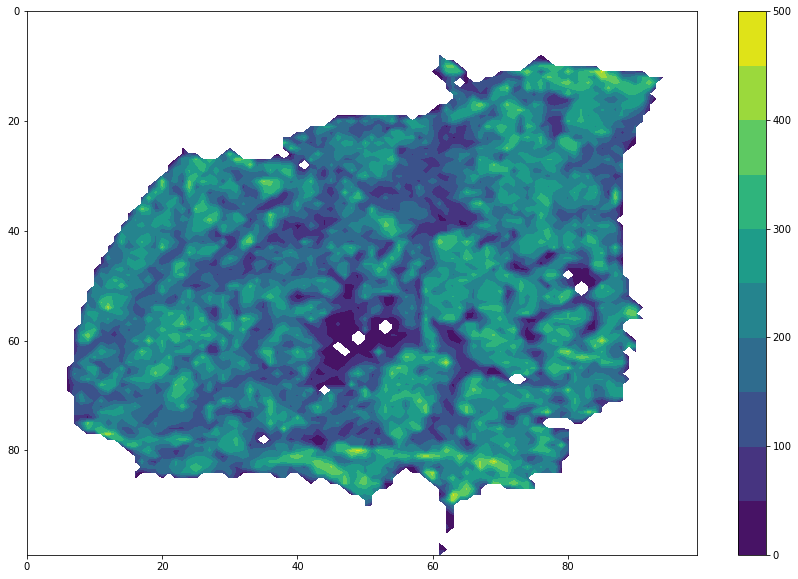

In [19]:
#for file in glob.glob('/home/garner1/Work/pipelines/WSI-analysis/SG/pipeline/data/HE/*.gz'):
for file in glob.glob('../data/HE/*.gz'):
    
    sample = os.path.basename(file).split(sep='.')[0]; print(sample)

    df = pd.read_csv(file,sep='\t')

    features = df.columns[7:]
    centroids = df.columns[5:7]

    # filter by percentiles in morphologies (hardcoded in function filtering) and introduce coeff. of var
    if size == 0:
        fdf = df # filter out extremes in morphology
    else:
        fdf = df.sample(n=size) # filter out morphological outlyers and subsample nuclei
    pos = fdf[centroids].to_numpy() # Get the positions of centroids 

    # Building the UMAP graph
    filename = '../py/ID'+str(sample)+'.size'+str(size)+'.nn'+str(nn)+'.graph.HE.npz' # the adj sparse matrix
    if path.exists(filename):
        print('The graph already exists')
        A = sparse.load_npz(filename) 
    else:
        print('Creating the graph')
        A = space2graph(pos,nn)
        sparse.save_npz(filename, A)


    filename = '../py/ID'+str(sample)+'.size'+str(size)+'.nn'+str(nn)+'.graph.HE.pickle'    # the networkx obj
    if path.exists(filename):    
        print('The network already exists')
        G = nx.read_gpickle(filename)
    else:
        print('Creating the network')
        G = nx.from_scipy_sparse_matrix(A, edge_attribute='weight')
        nx.write_gpickle(G, filename)

    data = fdf[features].to_numpy() #get the morphological data

    # Parallel generation of the local covd
    filename = '../py/ID'+str(sample)+'.size'+str(size)+'.nn'+str(nn)+'.descriptor.HE.pickle'    # the descriptor
    if path.exists(filename):    
        print('The descriptor already exists')
        descriptor = pickle.load( open( filename, "rb" ) )
    else:
        print('Generating the descriptor')
        num_cores = multiprocessing.cpu_count() # numb of cores
        row_idx, col_idx = A.nonzero() # nonzero entries
        processed_list = Parallel(n_jobs=num_cores)(delayed(covd_local)(r,A,data,row_idx,col_idx) 
                                                                for r in range(A.shape[0])
                                                       )

        # Construct the descriptor array
        descriptor = np.zeros((len(processed_list),processed_list[0][1].shape[0]))
        for r in range(len(processed_list)):
            descriptor[r,:] = processed_list[r][1] # covd descriptors of the connected nodes
        pickle.dump( descriptor, open( filename, "wb" ) )

    # Construct the local Laplacian
    L = nx.laplacian_matrix(G, weight='weight') # get the Laplacian matrix
    delta_descriptor = L.dot(descriptor) # get the local differianted descriptor
    delta = norm(delta_descriptor,axis=1) # get the norm of the differential field
    filename = './ID.'+str(sample)+'.size'+str(size)+'.nn'+str(nn)+'.bin'+str(N)+'.contour.HE.png'
    contourPlot(fdf,N,filename)